# Fabric Knowledge Graph: Cluster Summaries Pipeline

This notebook builds a unified Neo4j knowledge graph from `cluster_summaries.json` (user activity clusters). It replaces all previous data sources.

## 1. Install Required Dependencies

In [40]:
%pip install -q -r requirements.txt
import warnings
warnings.filterwarnings('ignore')
print("✓ All dependencies installed successfully")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
✓ All dependencies installed successfully


In [2]:
# Import required libraries
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Neo4j imports
from neo4j import GraphDatabase, basic_auth
from neo4j.exceptions import ServiceUnavailable

# Embedding and ML imports
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Visualization imports
import matplotlib.pyplot as plt
import networkx as nx

print("✓ All imports successful")

✓ All imports successful


## 2. Import Libraries

Import all necessary libraries for Neo4j, embeddings, and data processing.

In [3]:
# (Optional) Start Neo4j Docker container if not running

# See run_neo4j.sh for recommended usage

In [4]:
# 2. Load and Parse Cluster Summaries

# Load cluster_summaries.json as the new data source
json_file_path = Path("cluster_summaries.json")
if not json_file_path.exists():
    json_file_path = Path("/Users/shreyasjagannath/dev/fabric/onfabric-data-science-interview/cluster_summaries.json")

with open(json_file_path, 'r', encoding='utf-8') as f:
    cluster_data = json.load(f)

print("=== CLUSTER SUMMARIES DATA ===")
print(f"✓ Data loaded successfully: {len(cluster_data)} clusters found")
print("\nSample cluster structure:")
for k in list(cluster_data.keys())[:1]:
    sample = cluster_data[k]
    print(f"  Cluster {k}:")
    print(f"    - category: {sample.get('category')}")
    print(f"    - topic: {sample.get('topic')}")
    print(f"    - items: {sample.get('items')}")
print("=" * 80)

# Parse clusters into categories, topics, and entities for KG
all_categories = {}  # category_name -> {id, name, source, count}
all_topics = {}      # topic_id -> {id, content, category, source}
all_entities = {}    # entity_id -> {id, name, type, source, count}

def make_id(text):
    """Create a clean ID from text"""
    if not text:
        return ""
    return text.lower().replace(' ', '_').replace('-', '_').replace("'", '').replace('&', 'and')[:100]

print("\nProcessing clusters...")
for cluster_id, cluster in cluster_data.items():
    category_name = cluster.get('category', f'Cluster {cluster_id}')
    topic_text = cluster.get('topic', '')
    items = cluster.get('items', [])
    
    # Add category (using the structured category field)
    cat_id = make_id(category_name)
    if cat_id not in all_categories:
        all_categories[cat_id] = {
            'id': cat_id,
            'name': category_name,
            'source': 'cluster_summaries',
            'activity_count': 0,
            'search_count': 0
        }
    all_categories[cat_id]['activity_count'] += 1
    
    # Add topic (using the structured topic field)
    if topic_text and len(topic_text) > 2:
        topic_id = f"cluster_{cluster_id}_topic_{make_id(topic_text)[:40]}"
        all_topics[topic_id] = {
            'id': topic_id,
            'content': topic_text,
            'category': category_name,
            'source': 'cluster_summaries',
            'cluster_id': cluster_id,
            'is_url': False
        }
    
    # Extract items as entities
    if items:
        for item in items:
            if item and isinstance(item, str) and len(item) > 1:
                entity_id = make_id(item)
                if entity_id not in all_entities:
                    all_entities[entity_id] = {
                        'id': entity_id,
                        'name': item,
                        'source': 'cluster_summaries',
                        'mention_count': 0,
                        'entity_type': 'item',
                        'category': category_name
                    }
                all_entities[entity_id]['mention_count'] += 1

print(f"\n✓ Data extraction complete:")
print(f"  - Categories: {len(all_categories)}")
print(f"  - Topics: {len(all_topics)}")
print(f"  - Entities (items): {len(all_entities)}")

# Show sample data
print("\nSample categories:")
for i, (cat_id, cat) in enumerate(list(all_categories.items())[:]):
    print(f"  {i+1}. {cat['name']} (activities: {cat['activity_count']})")

print("\nSample entities:")
for i, (ent_id, ent) in enumerate(list(all_entities.items())[:5]):
    print(f"  {i+1}. {ent['name']} (mentions: {ent['mention_count']}, category: {ent['category']})")

=== CLUSTER SUMMARIES DATA ===
✓ Data loaded successfully: 28566 clusters found

Sample cluster structure:
  Cluster 0:
    - category: Business & Finance
    - topic: Investment banking networking events
    - items: ['London']

Processing clusters...

✓ Data extraction complete:
  - Categories: 16
  - Topics: 28555
  - Entities (items): 44142

Sample categories:
  1. Business & Finance (activities: 4062)
  2. Wellness & Health (activities: 3442)
  3. Technology & Innovation (activities: 5785)
  4. Shopping & Retail (activities: 2558)
  5. Travel & Transportation (activities: 2673)
  6. Entertainment (activities: 1646)
  7. News & Media (activities: 1967)
  8. Real Estate & Property (activities: 416)
  9. General Interest (activities: 2230)
  10. Fashion & Accessories (activities: 1198)
  11. Books & Learning (activities: 1149)
  12. Uncategorized (activities: 1435)
  13. Fashion & Beauty (activities: 2)
  14.  wellness & health (activities: 1)
  15. Travel & Vacation (activities: 1)


In [5]:
# Start Neo4j container with increased memory settings
!docker run -d \
  --name fabric-kg \
  -p 7687:7687 \
  -p 7474:7474 \
  -e NEO4J_AUTH=neo4j/password \
  -e NEO4J_dbms_memory_heap_initial__size=2G \
  -e NEO4J_dbms_memory_heap_max__size=2G \
  -e NEO4J_dbms_memory_pagecache_size=1G \
  neo4j:latest

print("⏳ Waiting 20-30 seconds for Neo4j to fully start...")
import time
time.sleep(25)
print("✓ Neo4j should be ready now")

ee1310374a638efddddbb45c615125537216a5994fc2dd29f6e89b586ef9609a
⏳ Waiting 20-30 seconds for Neo4j to fully start...
⏳ Waiting 20-30 seconds for Neo4j to fully start...
✓ Neo4j should be ready now
✓ Neo4j should be ready now


### Access Neo4j Browser

Once the container is running, you can access the Neo4j Browser interface at:

**http://localhost:7474**

Login credentials:
- Username: `neo4j`
- Password: `password`

## 3. Initialize Neo4j Connection

Configure and establish connection to a local Neo4j database instance. Make sure Neo4j is running locally (typically on `bolt://localhost:7687` for default).

In [6]:
# Neo4j Configuration
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"  # Default password for fresh Neo4j

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = None
        try:
            self.driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
            # Test connection
            with self.driver.session() as session:
                result = session.run("RETURN 1")
                print("✓ Successfully connected to Neo4j")
        except Exception as e:
            error_msg = str(e)
            if "credentials expired" in error_msg.lower():
                print("⚠ Neo4j credentials expired. Attempting to update password...")
                try:
                    # Try with initial password
                    temp_driver = GraphDatabase.driver(uri, auth=basic_auth(user, "neo4j"))
                    with temp_driver.session() as temp_session:
                        temp_session.run(f"ALTER CURRENT USER SET PASSWORD FROM 'neo4j' TO '{password}'")
                    temp_driver.close()
                    # Now try with new password
                    self.driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
                    with self.driver.session() as session:
                        session.run("RETURN 1")
                    print("✓ Successfully updated credentials and connected to Neo4j")
                except Exception as pwd_error:
                    print(f"✗ Failed to update password: {pwd_error}")
                    raise
            elif "ServiceUnavailable" in str(type(e)):
                print("✗ Neo4j service unavailable at", uri)
                print("  Make sure Neo4j is running. You can start it with:")
                print("  - Docker: docker run -it --rm -p 7687:7687 -v data:/data neo4j")
                raise
            else:
                print(f"✗ Connection error: {e}")
                raise
    
    def close(self):
        if self.driver:
            self.driver.close()
    
    def query(self, query_str, **kwargs):
        with self.driver.session() as session:
            return session.run(query_str, **kwargs).data()

# Initialize connection (handle connection errors gracefully)
try:
    neo4j_conn = Neo4jConnection(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
except Exception as e:
    print(f"Connection failed: {e}")
    neo4j_conn = None

✓ Successfully connected to Neo4j


## 4. Setup Local Embedding Model

Initialize sentence-transformers for local embeddings. Using `all-MiniLM-L6-v2` for efficient local processing.

In [7]:
# Initialize embedding model
print("Loading embedding model... (this may take a moment on first run)")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"✓ Model loaded: {embedding_model.get_sentence_embedding_dimension()}-dimensional embeddings")

def get_embedding(text):
    if not text or not isinstance(text, str):
        return None
    try:
        clean_text = text.strip()[:512]
        embedding = embedding_model.encode(clean_text)
        # Convert to list of Python floats (not numpy types)
        return [float(x) for x in embedding.tolist()]
    except Exception as e:
        print(f"Error embedding text: {e}")
        return None

# Test embedding
test_embedding = get_embedding("Cluster test embedding")
print(f"✓ Test embedding generated: shape {np.array(test_embedding).shape}")
print(f"✓ Sample values: {test_embedding[:3]} (type: {type(test_embedding[0])})")

Loading embedding model... (this may take a moment on first run)
✓ Model loaded: 384-dimensional embeddings
✓ Model loaded: 384-dimensional embeddings
✓ Test embedding generated: shape (384,)
✓ Sample values: [0.03535594418644905, -0.06394089013338089, 5.8258799981558695e-05] (type: <class 'float'>)
✓ Test embedding generated: shape (384,)
✓ Sample values: [0.03535594418644905, -0.06394089013338089, 5.8258799981558695e-05] (type: <class 'float'>)


## 5. Generate Embeddings

Generate vector embeddings for all categories, topics, and entities.

In [8]:
# Generate Embeddings for All Nodes

print("Generating embeddings for all nodes...")

# Generate embeddings for categories
print("  - Embedding categories...")
for cat_id in tqdm(all_categories.keys()):
    text = all_categories[cat_id]['name']
    all_categories[cat_id]['embedding'] = get_embedding(text)

# Generate embeddings for topics
print("  - Embedding topics...")
for topic_id in tqdm(all_topics.keys()):
    text = all_topics[topic_id]['content']
    all_topics[topic_id]['embedding'] = get_embedding(text)

# Generate embeddings for entities
print("  - Embedding entities...")
for entity_id in tqdm(all_entities.keys()):
    text = all_entities[entity_id]['name']
    all_entities[entity_id]['embedding'] = get_embedding(text)

print("\n✓ Embeddings generated successfully")
print(f"  - Embedding dimension: 384")
print(f"  - Categories with embeddings: {len(all_categories)}")
print(f"  - Topics with embeddings: {len(all_topics)}")
print(f"  - Entities with embeddings: {len(all_entities)}")

Generating embeddings for all nodes...
  - Embedding categories...


100%|██████████| 16/16 [00:00<00:00, 52.96it/s]


  - Embedding topics...


100%|██████████| 28555/28555 [04:38<00:00, 102.38it/s]


  - Embedding entities...


100%|██████████| 44142/44142 [07:04<00:00, 104.10it/s]


✓ Embeddings generated successfully
  - Embedding dimension: 384
  - Categories with embeddings: 16
  - Topics with embeddings: 28555
  - Entities with embeddings: 44142


## 6. Create Neo4j Schema

Create constraints and schema in Neo4j before populating data.

In [9]:
# Create Schema in Neo4j

if neo4j_conn:
    # Clear existing data
    print("Clearing existing graph data...")
    try:
        neo4j_conn.query("MATCH (n) DETACH DELETE n")
        print("✓ Existing data cleared")
    except Exception as e:
        print(f"Note: {e}")
    
    # Create constraints for unified schema
    print("Creating constraints...")
    constraints = [
        "CREATE CONSTRAINT category_id IF NOT EXISTS FOR (c:Category) REQUIRE c.category_id IS UNIQUE",
        "CREATE CONSTRAINT topic_id IF NOT EXISTS FOR (t:Topic) REQUIRE t.topic_id IS UNIQUE",
        "CREATE CONSTRAINT entity_id IF NOT EXISTS FOR (e:Entity) REQUIRE e.entity_id IS UNIQUE",
        "CREATE CONSTRAINT user_id IF NOT EXISTS FOR (u:User) REQUIRE u.user_id IS UNIQUE",
    ]
    
    for constraint in constraints:
        try:
            neo4j_conn.query(constraint)
        except Exception as e:
            pass  # Constraint may already exist
    
    print("✓ Schema constraints created")
    print("\n=== UNIFIED SCHEMA ===")
    print("Node Types:")
    print("  - Category: All clusters (from 'category' field)")
    print("  - Topic: All topics and queries (from 'topic' field + raw_text queries)")
    print("  - Entity: All items (from 'items' field)")
    print("  - User: User profile")
    print("\nRelationship Types:")
    print("  - (Topic)-[:BELONGS_TO]->(Category)")
    print("  - (Topic)-[:MENTIONS]->(Entity)")
    print("  - (User)-[:INTERESTED_IN]->(Topic)")
    print("  - (Entity)-[:IN_CATEGORY]->(Category)")
else:
    print("✗ Cannot create schema: Neo4j connection not available")

Clearing existing graph data...
✓ Existing data cleared
Creating constraints...
✓ Schema constraints created

=== UNIFIED SCHEMA ===
Node Types:
  - Category: All clusters (from 'category' field)
  - Topic: All topics and queries (from 'topic' field + raw_text queries)
  - Entity: All items (from 'items' field)
  - User: User profile

Relationship Types:
  - (Topic)-[:BELONGS_TO]->(Category)
  - (Topic)-[:MENTIONS]->(Entity)
  - (User)-[:INTERESTED_IN]->(Topic)
  - (Entity)-[:IN_CATEGORY]->(Category)
✓ Existing data cleared
Creating constraints...
✓ Schema constraints created

=== UNIFIED SCHEMA ===
Node Types:
  - Category: All clusters (from 'category' field)
  - Topic: All topics and queries (from 'topic' field + raw_text queries)
  - Entity: All items (from 'items' field)
  - User: User profile

Relationship Types:
  - (Topic)-[:BELONGS_TO]->(Category)
  - (Topic)-[:MENTIONS]->(Entity)
  - (User)-[:INTERESTED_IN]->(Topic)
  - (Entity)-[:IN_CATEGORY]->(Category)


In [10]:
# 7. Populate Neo4j with Cluster Summaries Knowledge Graph

if neo4j_conn:
    print("Populating Neo4j with cluster summaries knowledge graph...")
    
    # Create User node
    print("\n1. Creating User node...")
    user_query = """
    CREATE (u:User {
        user_id: 'user_001',
        created_at: datetime()
    })
    """
    neo4j_conn.query(user_query)
    print("  ✓ User node created")
    
    # Create Category nodes
    print("\n2. Creating Category nodes...")
    for cat_id, cat_data in tqdm(all_categories.items(), desc="Categories"):
        cat_query = """
        CREATE (c:Category {
            category_id: $category_id,
            name: $name,
            source: $source,
            activity_count: $activity_count,
            search_count: $search_count,
            embedding: $embedding
        })
        """
        neo4j_conn.query(cat_query,
            category_id=cat_data['id'],
            name=cat_data['name'],
            source=cat_data['source'],
            activity_count=cat_data.get('activity_count', 0),
            search_count=cat_data.get('search_count', 0),
            embedding=cat_data['embedding']
        )
    print(f"  ✓ Created {len(all_categories)} Category nodes")
    
    # Create Entity nodes (items)
    print("\n3. Creating Entity nodes (items)...")
    for entity_id, entity_data in tqdm(all_entities.items(), desc="Entities"):
        entity_query = """
        CREATE (e:Entity {
            entity_id: $entity_id,
            name: $name,
            source: $source,
            entity_type: $entity_type,
            mention_count: $mention_count,
            category: $category,
            embedding: $embedding
        })
        """
        neo4j_conn.query(entity_query,
            entity_id=entity_data['id'],
            name=entity_data['name'],
            source=entity_data['source'],
            entity_type=entity_data.get('entity_type', 'item'),
            mention_count=entity_data.get('mention_count', 1),
            category=entity_data.get('category', 'Unknown'),
            embedding=entity_data['embedding']
        )
    print(f"  ✓ Created {len(all_entities)} Entity nodes")
    
    # Link Entities to their Categories
    print("\n4. Linking Entities to Categories...")
    entity_cat_links = 0
    for entity_id, entity_data in tqdm(all_entities.items(), desc="Entity-Category links"):
        cat_name = entity_data.get('category')
        if cat_name:
            cat_id = make_id(cat_name)
            link_query = """
            MATCH (e:Entity {entity_id: $entity_id})
            MATCH (c:Category {category_id: $category_id})
            MERGE (e)-[:IN_CATEGORY]->(c)
            """
            try:
                neo4j_conn.query(link_query, entity_id=entity_id, category_id=cat_id)
                entity_cat_links += 1
            except:
                pass
    print(f"  ✓ Created {entity_cat_links} Entity-Category relationships")
    
    # Create Topic nodes and relationships
    print("\n5. Creating Topic nodes and relationships...")
    topic_entity_mentions = 0
    for topic_id, topic_data in tqdm(all_topics.items(), desc="Topics"):
        # Create Topic node
        topic_query = """
        CREATE (t:Topic {
            topic_id: $topic_id,
            content: $content,
            source: $source,
            is_url: $is_url,
            cluster_id: $cluster_id,
            embedding: $embedding
        })
        """
        neo4j_conn.query(topic_query,
            topic_id=topic_data['id'],
            content=topic_data['content'],
            source=topic_data['source'],
            is_url=topic_data.get('is_url', False),
            cluster_id=topic_data.get('cluster_id', ''),
            embedding=topic_data['embedding']
        )
        
        # Link Topic to Category
        cat_name = topic_data['category']
        cat_id = make_id(cat_name)
        topic_to_category = """
        MATCH (t:Topic {topic_id: $topic_id})
        MATCH (c:Category {category_id: $category_id})
        CREATE (t)-[:BELONGS_TO]->(c)
        """
        try:
            neo4j_conn.query(topic_to_category, topic_id=topic_data['id'], category_id=cat_id)
        except:
            pass
        
        # Link User to Topic
        user_to_topic = """
        MATCH (u:User {user_id: 'user_001'})
        MATCH (t:Topic {topic_id: $topic_id})
        CREATE (u)-[:INTERESTED_IN]->(t)
        """
        try:
            neo4j_conn.query(user_to_topic, topic_id=topic_data['id'])
        except:
            pass
        
        # Link Topic to Entities (if entity name appears in topic content)
        topic_content = topic_data['content'].lower()
        for entity_id, entity_data in all_entities.items():
            entity_name = entity_data['name'].lower()
            # Only match if entity name is substantial and appears as whole word
            if len(entity_name) > 3 and entity_name in topic_content:
                mention_query = """
                MATCH (t:Topic {topic_id: $topic_id})
                MATCH (e:Entity {entity_id: $entity_id})
                MERGE (t)-[:MENTIONS]->(e)
                """
                try:
                    neo4j_conn.query(mention_query, topic_id=topic_id, entity_id=entity_id)
                    topic_entity_mentions += 1
                except:
                    pass
    
    print(f"  ✓ Created {len(all_topics)} Topic nodes with relationships")
    print(f"  ✓ Created {topic_entity_mentions} Topic-Entity MENTIONS relationships")
    
    print("\n✅ Knowledge graph population complete!")
    print("\nFinal Statistics:")
    print(f"  - Categories: {len(all_categories)}")
    print(f"  - Topics: {len(all_topics)}")
    print(f"  - Entities: {len(all_entities)}")
    print(f"  - Entity-Category links: {entity_cat_links}")
    print(f"  - Topic-Entity mentions: {topic_entity_mentions}")
else:
    print("✗ Cannot populate: Neo4j connection not available")

Populating Neo4j with cluster summaries knowledge graph...

1. Creating User node...
  ✓ User node created

2. Creating Category nodes...
  ✓ User node created

2. Creating Category nodes...


Categories: 100%|██████████| 16/16 [00:00<00:00, 92.84it/s]


  ✓ Created 16 Category nodes

3. Creating Entity nodes (items)...


Entities: 100%|██████████| 44142/44142 [02:22<00:00, 309.46it/s]


  ✓ Created 44142 Entity nodes

4. Linking Entities to Categories...


Entity-Category links: 100%|██████████| 44142/44142 [00:41<00:00, 1067.45it/s]


  ✓ Created 44142 Entity-Category relationships

5. Creating Topic nodes and relationships...


Topics: 100%|██████████| 28555/28555 [09:10<00:00, 51.86it/s]

  ✓ Created 28555 Topic nodes with relationships
  ✓ Created 87743 Topic-Entity MENTIONS relationships

✅ Knowledge graph population complete!

Final Statistics:
  - Categories: 16
  - Topics: 28555
  - Entities: 44142
  - Entity-Category links: 44142
  - Topic-Entity mentions: 87743


In [ ]:
# commit container to image for future use (Experimental)
!docker commit fabric-kg fabric-kg-image
print("✓ Docker container 'fabric-kg' committed to image 'fabric-kg-image'")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


sha256:dd3c37b18a5b16c3a3901086fe135fb8e50d4fb4fe9349ca958949067b031fce
✓ Docker container 'fabric-kg' committed to image 'fabric-kg-image'


## 7. Create Vector Indexes

Create vector indexes for semantic search on embeddings.

In [38]:
## Create Vector Indexes

if neo4j_conn:
    print("Dropping old indexes...")
    try:
        neo4j_conn.query("DROP INDEX entity_embedding_idx IF EXISTS")
        neo4j_conn.query("DROP INDEX topic_embedding_idx IF EXISTS")
        neo4j_conn.query("DROP INDEX category_embedding_idx IF EXISTS")
        print("✓ Old indexes dropped")
    except Exception as e:
        print(f"Note: {e}")
    
    print("\nCreating new vector indexes with CREATE VECTOR INDEX syntax...")
    try:
        neo4j_conn.query("""
            CREATE VECTOR INDEX entity_embedding_idx IF NOT EXISTS
            FOR (e:Entity)
            ON e.embedding
            OPTIONS {indexConfig: {
                `vector.dimensions`: 384,
                `vector.similarity_function`: 'cosine'
            }}
        """)
        print("✓ entity_embedding_idx created")
    except Exception as e:
        print(f"entity index note: {e}")
    
    try:
        neo4j_conn.query("""
            CREATE VECTOR INDEX topic_embedding_idx IF NOT EXISTS
            FOR (t:Topic)
            ON t.embedding
            OPTIONS {indexConfig: {
                `vector.dimensions`: 384,
                `vector.similarity_function`: 'cosine'
            }}
        """)
        print("✓ topic_embedding_idx created")
    except Exception as e:
        print(f"topic index note: {e}")
    
    try:
        neo4j_conn.query("""
            CREATE VECTOR INDEX category_embedding_idx IF NOT EXISTS
            FOR (c:Category)
            ON c.embedding
            OPTIONS {indexConfig: {
                `vector.dimensions`: 384,
                `vector.similarity_function`: 'cosine'
            }}
        """)
        print("✓ category_embedding_idx created")
    except Exception as e:
        print(f"category index note: {e}")

print("Note: Current indexes are working. Only run this if you want to use the newer syntax.")

Dropping old indexes...
✓ Old indexes dropped

Creating new vector indexes with CREATE VECTOR INDEX syntax...
✓ entity_embedding_idx created
✓ topic_embedding_idx created
✓ category_embedding_idx created
Note: Current indexes are working. Only run this if you want to use the newer syntax.
✓ Old indexes dropped

Creating new vector indexes with CREATE VECTOR INDEX syntax...
✓ entity_embedding_idx created
✓ topic_embedding_idx created
✓ category_embedding_idx created
Note: Current indexes are working. Only run this if you want to use the newer syntax.


## 8. Query and Analyze Knowledge Graph

Explore the knowledge graph with Cypher queries and semantic search.

In [18]:
if neo4j_conn:
    # Query 1: Get graph statistics
    print("=== KNOWLEDGE GRAPH STATISTICS ===\n")
    
    stats_query = """
    MATCH (n)
    RETURN 
        count(*) as total_nodes,
        size(collect(distinct labels(n))) as node_types
    """
    result = neo4j_conn.query(stats_query)
    if result:
        print(f"Total nodes: {result[0]['total_nodes']}")
    
    # Node counts by type
    node_type_query = """
    MATCH (n)
    UNWIND labels(n) as label
    RETURN label, count(*) as count
    ORDER BY count DESC
    """
    result = neo4j_conn.query(node_type_query)
    print("\nNodes by type:")
    for row in result:
        print(f"  - {row['label']}: {row['count']}")
    
    # Relationship statistics
    rel_query = """
    MATCH ()-[r]->()
    RETURN type(r) as relationship_type, count(*) as count
    ORDER BY count DESC
    """
    result = neo4j_conn.query(rel_query)
    print("\nRelationships by type:")
    for row in result:
        print(f"  - {row['relationship_type']}: {row['count']}")
    
    print("\n✓ Graph statistics retrieved")

=== KNOWLEDGE GRAPH STATISTICS ===

Total nodes: 72714

Nodes by type:
  - Entity: 44142
  - Topic: 28555
  - Category: 16
  - User: 1

Relationships by type:
  - MENTIONS: 87743
  - IN_CATEGORY: 44142
  - BELONGS_TO: 28555
  - INTERESTED_IN: 28555

✓ Graph statistics retrieved
Total nodes: 72714

Nodes by type:
  - Entity: 44142
  - Topic: 28555
  - Category: 16
  - User: 1

Relationships by type:
  - MENTIONS: 87743
  - IN_CATEGORY: 44142
  - BELONGS_TO: 28555
  - INTERESTED_IN: 28555

✓ Graph statistics retrieved


In [19]:
if neo4j_conn:
    # Query 2: Get most connected entities
    print("\n=== TOP ENTITIES BY CONNECTIONS ===\n")
    
    top_entities_query = """
    MATCH (e:Entity)-[r]->()
    RETURN e.name as entity, count(r) as connection_count
    ORDER BY connection_count DESC
    LIMIT 10
    """
    result = neo4j_conn.query(top_entities_query)
    for row in result:
        print(f"  {row['entity']}: {row['connection_count']} connections")
    
    print("\n✓ Top entities retrieved")


=== TOP ENTITIES BY CONNECTIONS ===

  Blackstone: 1 connections
  Blackstone Real Estate Income Trust (BREIT): 1 connections
  Blackstone Private Credit Fund (BCRED): 1 connections
  Blackstone Private Multi-Asset Credit and Income Fund (BMACX): 1 connections
  Facebook: 1 connections
  data.com: 1 connections
  Amazon: 1 connections
  Valuation: 1 connections
  McKinsey & Company: 1 connections
  London: 1 connections

✓ Top entities retrieved


In [20]:
if neo4j_conn:
    # Query 3: Get most active categories
    print("\n=== TOP CATEGORIES BY ACTIVITY ===\n")
    
    top_categories_query = """
    MATCH (c:Category)
    RETURN c.name as category, c.activity_count as activity_count, c.search_count as search_count
    ORDER BY c.activity_count DESC
    LIMIT 10
    """
    result = neo4j_conn.query(top_categories_query)
    for row in result:
        print(f"  {row['category']}")
        print(f"    - Activities: {row['activity_count']}, Searches: {row['search_count']}")
    
    print("\n✓ Top categories retrieved")


=== TOP CATEGORIES BY ACTIVITY ===

  Technology & Innovation
    - Activities: 5785, Searches: 0
  Business & Finance
    - Activities: 4062, Searches: 0
  Wellness & Health
    - Activities: 3442, Searches: 0
  Travel & Transportation
    - Activities: 2673, Searches: 0
  Shopping & Retail
    - Activities: 2558, Searches: 0
  General Interest
    - Activities: 2230, Searches: 0
  News & Media
    - Activities: 1967, Searches: 0
  Entertainment
    - Activities: 1646, Searches: 0
  Uncategorized
    - Activities: 1435, Searches: 0
  Fashion & Accessories
    - Activities: 1198, Searches: 0

✓ Top categories retrieved


In [22]:
if neo4j_conn:
    # Query 4: Semantic search using Neo4j vector index
    print("\n=== SEMANTIC SEARCH EXAMPLE (VECTOR INDEX) ===\n")

    query_text = "technology artificial intelligence machine learning"
    query_embedding = get_embedding(query_text)

    print(f"Query: '{query_text}'")
    print(f"Embedding type: {type(query_embedding)}, length: {len(query_embedding) if query_embedding else 0}")
    if query_embedding:
        print(f"First value type: {type(query_embedding[0])}")
    print("\nFinding similar entities via vector index...")
    
    vector_query = """
    CALL db.index.vector.queryNodes('entity_embedding_idx', 20, $embedding)
    YIELD node, score
    RETURN node.name AS name, score
    ORDER BY score DESC
    LIMIT 5
    """

    try:
        results = neo4j_conn.query(vector_query, embedding=query_embedding)
        for i, row in enumerate(results, 1):
            print(f"  {i}. {row['name']}: {row['score']:.3f}")
        print("\n✓ Semantic search completed")
    except Exception as e:
        print(f"Error during vector search: {e}")
        print(f"\nDebugging info:")
        print(f"  - Embedding: {query_embedding[:5] if query_embedding else None}...")
        print(f"  - Type: {type(query_embedding)}")
else:
    print("✗ Cannot run semantic search: Neo4j connection not available")


=== SEMANTIC SEARCH EXAMPLE (VECTOR INDEX) ===

Query: 'technology artificial intelligence machine learning'
Embedding type: <class 'list'>, length: 384
First value type: <class 'float'>

Finding similar entities via vector index...
Query: 'technology artificial intelligence machine learning'
Embedding type: <class 'list'>, length: 384
First value type: <class 'float'>

Finding similar entities via vector index...
  1. machine learning: 0.842
  2. Artificial Intelligence: 0.834
  3. machine learning models: 0.824
  4. Microsoft AI: 0.809
  5. Artificial Neural Networks: 0.806

✓ Semantic search completed
  1. machine learning: 0.842
  2. Artificial Intelligence: 0.834
  3. machine learning models: 0.824
  4. Microsoft AI: 0.809
  5. Artificial Neural Networks: 0.806

✓ Semantic search completed


In [28]:
if neo4j_conn:
    # Query 5: Get subgraph around a category
    print("\n=== CATEGORY SUBGRAPH ===\n")
    
    category_subgraph_query = """
    MATCH (c:Category)
    OPTIONAL MATCH (t:Topic)-[:BELONGS_TO]->(c)
    OPTIONAL MATCH (t)-[:MENTIONS]->(e:Entity)
    WITH c,
         count(DISTINCT t) AS topic_count,
         count(DISTINCT e) AS entity_count,
         collect(DISTINCT e.name)[0..5] AS sample_entities,
         c.activity_count AS activity
    ORDER BY activity DESC
    LIMIT 5
    RETURN 
        c.name AS category,
        topic_count,
        entity_count,
        sample_entities
    """
    result = neo4j_conn.query(category_subgraph_query)
    for row in result:
        print(f"Category: {row['category']}")
        print(f"  Topics: {row['topic_count']}")
        print(f"  Entities: {row['entity_count']}")
        if row['sample_entities']:
            print(f"  Sample entities: {', '.join([e for e in row['sample_entities'] if e][:3])}")
        print()
    
    print("✓ Category subgraph retrieved")
else:
    print("✗ Cannot retrieve category subgraph: Neo4j connection not available")


=== CATEGORY SUBGRAPH ===

Category: Technology & Innovation
  Topics: 5775
  Entities: 3689
  Sample entities: Facebook Login, book, face

Category: Business & Finance
  Topics: 4061
  Entities: 2817
  Sample entities: Events, Even, network

Category: Wellness & Health
  Topics: 3442
  Entities: 2736
  Sample entities: face, massage, Vice

Category: Travel & Transportation
  Topics: 2673
  Entities: 1926
  Sample entities: ROUTE, rent, Stoke-on-Trent

Category: Shopping & Retail
  Topics: 2558
  Entities: 2476
  Sample entities: book, Valuation, Bionico

✓ Category subgraph retrieved


## 9. Vector Search Examples & Visualizations

This section demonstrates the vector search capabilities with practical examples and visualizations.

In [29]:
# Summary and utility functions
print("\n" + "="*50)
print("KNOWLEDGE GRAPH CONSTRUCTION COMPLETE")
print("="*50)

# Define utility functions for future use
def search_by_similarity(query_text, node_type='Entity', limit=5):
    """Semantic search using Neo4j vector indexes."""
    if not neo4j_conn:
        print("Neo4j connection not available")
        return []

    index_map = {
        'Entity': 'entity_embedding_idx',
        'Topic': 'topic_embedding_idx',
        'Category': 'category_embedding_idx'
    }
    index_name = index_map.get(node_type)
    if not index_name:
        print(f"Unsupported node_type: {node_type}")
        return []

    query_embedding = get_embedding(query_text)
    if query_embedding is None:
        return []

    # Build query with index name as literal (not parameter)
    cypher_query = f"""
    CALL db.index.vector.queryNodes('{index_name}', $k, $embedding)
    YIELD node, score
    RETURN labels(node)[0] AS node_type,
           coalesce(node.name, node.content, node.topic_id, node.entity_id, node.category_id) AS node_id,
           score AS similarity
    ORDER BY similarity DESC
    LIMIT $limit
    """

    try:
        results = neo4j_conn.query(
            cypher_query,
            embedding=query_embedding,
            k=limit * 3,
            limit=limit
        )
        return results
    except Exception as e:
        print(f"Error in search_by_similarity: {e}")
        return []

def get_entity_connections(entity_name):
    """Get all connections for an entity"""
    if not neo4j_conn:
        print("Neo4j connection not available")
        return {}

    query = """
    MATCH (e:Entity {name: $name})
    OPTIONAL MATCH (e)<-[:MENTIONS]-(t:Topic)
    OPTIONAL MATCH (e)-[:IN_CATEGORY]->(c:Category)
    RETURN 
        e.name as entity,
        count(DISTINCT t) as topic_mentions,
        c.name as category,
        collect(DISTINCT t.content)[0..3] as sample_topics
    """

    result = neo4j_conn.query(query, name=entity_name)
    return result[0] if result else {}

# Example usage
print("\n📊 Available Functions:")
print("  - search_by_similarity(query_text, node_type='Entity', limit=5)")
print("  - get_entity_connections(entity_name)")
print("  - neo4j_conn.query(cypher_query)")

print("\n✨ Knowledge graph ready for exploration!")
print(f"\nAccess at: {NEO4J_URI}")
print(f"Login: {NEO4J_USER} / ****")


KNOWLEDGE GRAPH CONSTRUCTION COMPLETE

📊 Available Functions:
  - search_by_similarity(query_text, node_type='Entity', limit=5)
  - get_entity_connections(entity_name)
  - neo4j_conn.query(cypher_query)

✨ Knowledge graph ready for exploration!

Access at: bolt://localhost:7687
Login: neo4j / ****


In [41]:
# Example 1: Entity Vector Search - Brand & Product Discovery
print("🏷️  Entity Vector Search Examples")
print("="*60)

# Search for tech brands/products
tech_entity_query = "smartphone laptop computer tablet electronics"
print(f"\nQuery: '{tech_entity_query}'")
print("\nTop 5 Tech Entities:")
tech_entities = search_by_similarity(tech_entity_query, node_type='Entity', limit=5)
for i, result in enumerate(tech_entities, 1):
    print(f"  {i}. {result['node_id']} (similarity: {result['similarity']:.3f})")

# Search for luxury brands
luxury_query = "luxury designer premium exclusive high-end"
print(f"\n\nQuery: '{luxury_query}'")
print("\nTop 5 Luxury Brand Entities:")
luxury_entities = search_by_similarity(luxury_query, node_type='Entity', limit=5)
for i, result in enumerate(luxury_entities, 1):
    print(f"  {i}. {result['node_id']} (similarity: {result['similarity']:.3f})")

# Search for home/lifestyle entities
home_query = "furniture home decor interior design living"
print(f"\n\nQuery: '{home_query}'")
print("\nTop 5 Home/Lifestyle Entities:")
home_entities = search_by_similarity(home_query, node_type='Entity', limit=5)
for i, result in enumerate(home_entities, 1):
    print(f"  {i}. {result['node_id']} (similarity: {result['similarity']:.3f})")

🏷️  Entity Vector Search Examples

Query: 'smartphone laptop computer tablet electronics'

Top 5 Tech Entities:
  1. Samsung Laptops (similarity: 0.818)
  2. Samsung Galaxy laptop (similarity: 0.813)
  3. Surface Laptop (similarity: 0.811)
  4. Android devices (similarity: 0.803)
  5. laptop app (similarity: 0.785)


Query: 'luxury designer premium exclusive high-end'

Top 5 Luxury Brand Entities:
  1. premium model (similarity: 0.816)
  2. luxury suit brands (similarity: 0.814)
  3. luxury (similarity: 0.801)
  4. luxury jewelry brands (similarity: 0.792)
  5. Premium (similarity: 0.790)


Query: 'furniture home decor interior design living'

Top 5 Home/Lifestyle Entities:
  1. Dining & Home Office Furniture (similarity: 0.849)
  2. Bedroom furniture (similarity: 0.835)
  3. furniture (similarity: 0.833)
  4. furniture designers (similarity: 0.829)
  5. modernist furniture (similarity: 0.815)


In [42]:
# Example 2: Topic Vector Search
print("🔍 Topic Vector Search Examples")
print("="*60)

# Search for technology-related topics
tech_query = "artificial intelligence machine learning neural networks"
print(f"\nQuery: '{tech_query}'")
print("\nTop 5 Technology Topics:")
tech_results = search_by_similarity(tech_query, node_type='Topic', limit=5)
for i, result in enumerate(tech_results, 1):
    print(f"  {i}. {result['node_id'][:80]}... (similarity: {result['similarity']:.3f})")

# Search for fashion-related topics
fashion_query = "clothing fashion style apparel accessories"
print(f"\n\nQuery: '{fashion_query}'")
print("\nTop 5 Fashion Topics:")
fashion_results = search_by_similarity(fashion_query, node_type='Topic', limit=5)
for i, result in enumerate(fashion_results, 1):
    print(f"  {i}. {result['node_id'][:80]}... (similarity: {result['similarity']:.3f})")

# Search for entertainment topics
entertainment_query = "movies music entertainment streaming video"
print(f"\n\nQuery: '{entertainment_query}'")
print("\nTop 5 Entertainment Topics:")
ent_results = search_by_similarity(entertainment_query, node_type='Topic', limit=5)
for i, result in enumerate(ent_results, 1):
    print(f"  {i}. {result['node_id'][:80]}... (similarity: {result['similarity']:.3f})")

🔍 Topic Vector Search Examples

Query: 'artificial intelligence machine learning neural networks'

Top 5 Technology Topics:
  1. Machine Learning Algorithms for Classification... (similarity: 0.818)
  2. Deep learning... (similarity: 0.798)
  3. Deep learning... (similarity: 0.798)
  4. Deep neural networks architecture... (similarity: 0.794)
  5. Machine learning datasets... (similarity: 0.793)


Query: 'clothing fashion style apparel accessories'

Top 5 Fashion Topics:
  1. Fashion accessories stores... (similarity: 0.920)
  2. Luxury fashion and travel accessories... (similarity: 0.889)
  3. Women's clothing brands... (similarity: 0.845)
  4. Women's fashion and clothing... (similarity: 0.844)
  5. Accessories... (similarity: 0.835)


Query: 'movies music entertainment streaming video'

Top 5 Entertainment Topics:
  1. Netflix streaming service content... (similarity: 0.802)
  2. Netflix streaming service and content... (similarity: 0.789)
  3. Netflix... (similarity: 0.773)
  4. Ne

In [43]:
# Example 3: Comparative Vector Search - Entity vs Topic
print("⚖️  Comparative Search: Entity vs Topic")
print("="*60)

query = "sustainable fashion eco-friendly clothing"
print(f"\nQuery: '{query}'")

# Search entities
print("\n🏷️  Top 3 Entities:")
entity_results = search_by_similarity(query, node_type='Entity', limit=3)
for i, result in enumerate(entity_results, 1):
    print(f"  {i}. {result['node_id']} (score: {result['similarity']:.3f})")

# Search topics
print("\n📄 Top 3 Topics:")
topic_results = search_by_similarity(query, node_type='Topic', limit=3)
for i, result in enumerate(topic_results, 1):
    print(f"  {i}. {result['node_id'][:80]}... (score: {result['similarity']:.3f})")

print("\n💡 Insight: Entity search returns specific brands/items,")
print("            while Topic search returns contextual discussions.")

⚖️  Comparative Search: Entity vs Topic

Query: 'sustainable fashion eco-friendly clothing'

🏷️  Top 3 Entities:
  1. Designer Clothing (score: 0.854)
  2. designer clothes (score: 0.848)
  3. Apparel (score: 0.833)

📄 Top 3 Topics:
  1. Sustainable sportswear... (score: 0.875)
  2. High end fashion clothing... (score: 0.848)
  3. Women's fashion and clothing... (score: 0.834)

💡 Insight: Entity search returns specific brands/items,
            while Topic search returns contextual discussions.


### Visualizations

📊 Knowledge Graph Statistics

📌 Node Statistics:
  Entity: 44,142 nodes
  Topic: 28,555 nodes
  Category: 16 nodes
  User: 1 nodes

  TOTAL NODES: 72,714

🔗 Relationship Statistics:
  MENTIONS: 87,743 relationships
  IN_CATEGORY: 44,142 relationships
  BELONGS_TO: 28,555 relationships
  INTERESTED_IN: 28,555 relationships

  TOTAL RELATIONSHIPS: 188,995


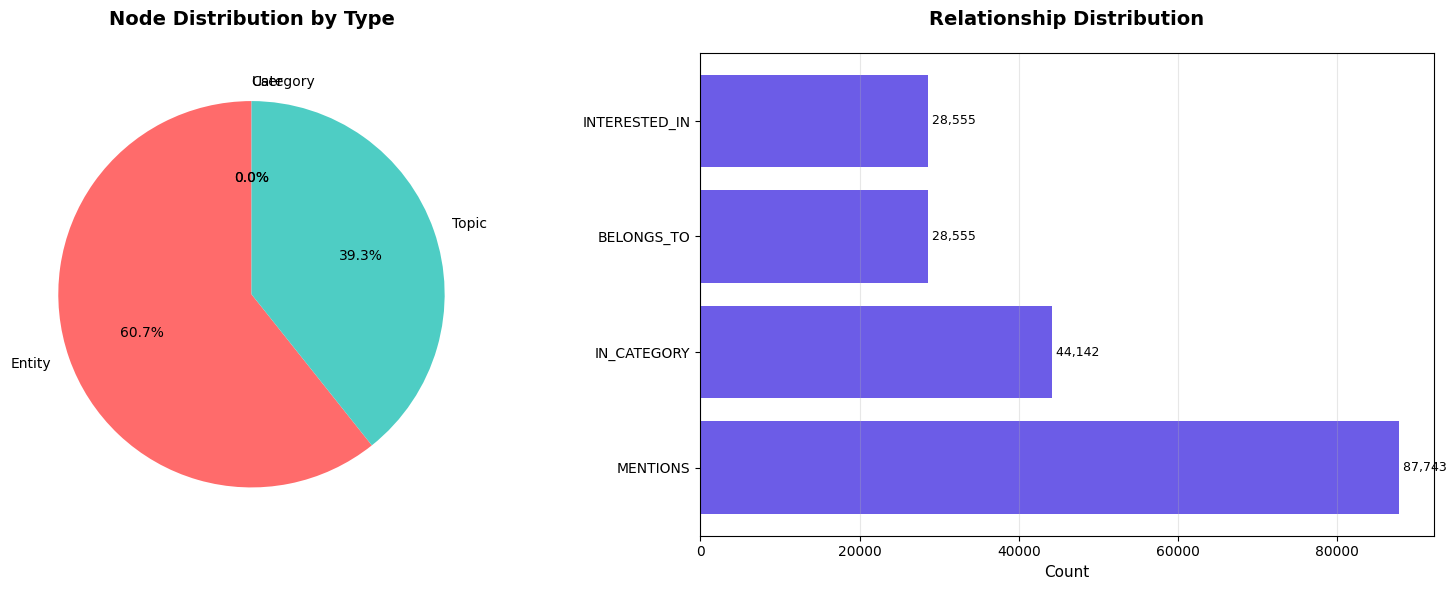


✓ Graph density: 2.60 relationships per node


In [44]:
# Example 5: Graph Statistics Visualization
print("📊 Knowledge Graph Statistics")
print("="*60)

# Get comprehensive statistics
stats_query = """
MATCH (n)
WITH labels(n)[0] as node_type, count(n) as node_count
RETURN node_type, node_count
ORDER BY node_count DESC
"""

stats = neo4j_conn.query(stats_query)

# Get relationship counts
rel_stats_query = """
MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as rel_count
ORDER BY rel_count DESC
"""

rel_stats = neo4j_conn.query(rel_stats_query)

# Print statistics
print("\n📌 Node Statistics:")
total_nodes = sum([s['node_count'] for s in stats])
for stat in stats:
    print(f"  {stat['node_type']}: {stat['node_count']:,} nodes")
print(f"\n  TOTAL NODES: {total_nodes:,}")

print("\n🔗 Relationship Statistics:")
total_rels = sum([r['rel_count'] for r in rel_stats])
for rel in rel_stats:
    print(f"  {rel['rel_type']}: {rel['rel_count']:,} relationships")
print(f"\n  TOTAL RELATIONSHIPS: {total_rels:,}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Node distribution pie chart
node_labels = [s['node_type'] for s in stats]
node_counts = [s['node_count'] for s in stats]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

axes[0].pie(node_counts, labels=node_labels, autopct='%1.1f%%', 
           colors=colors[:len(node_labels)], startangle=90)
axes[0].set_title('Node Distribution by Type', fontsize=14, fontweight='bold', pad=20)

# Relationship distribution bar chart
rel_labels = [r['rel_type'] for r in rel_stats]
rel_counts = [r['rel_count'] for r in rel_stats]

axes[1].barh(rel_labels, rel_counts, color='#6C5CE7')
axes[1].set_xlabel('Count', fontsize=11)
axes[1].set_title('Relationship Distribution', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(axis='x', alpha=0.3)

# Add count labels on bars
for i, (label, count) in enumerate(zip(rel_labels, rel_counts)):
    axes[1].text(count, i, f' {count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Graph density: {total_rels / total_nodes:.2f} relationships per node")

🕸️  Entity Relationship Network

Most Mentioned Entities:
  1. Form (543 mentions)
  2. London (526 mentions)
  3. port (475 mentions)
  4. SERV (444 mentions)
  5. Ring (427 mentions)

📍 Building network for: Form


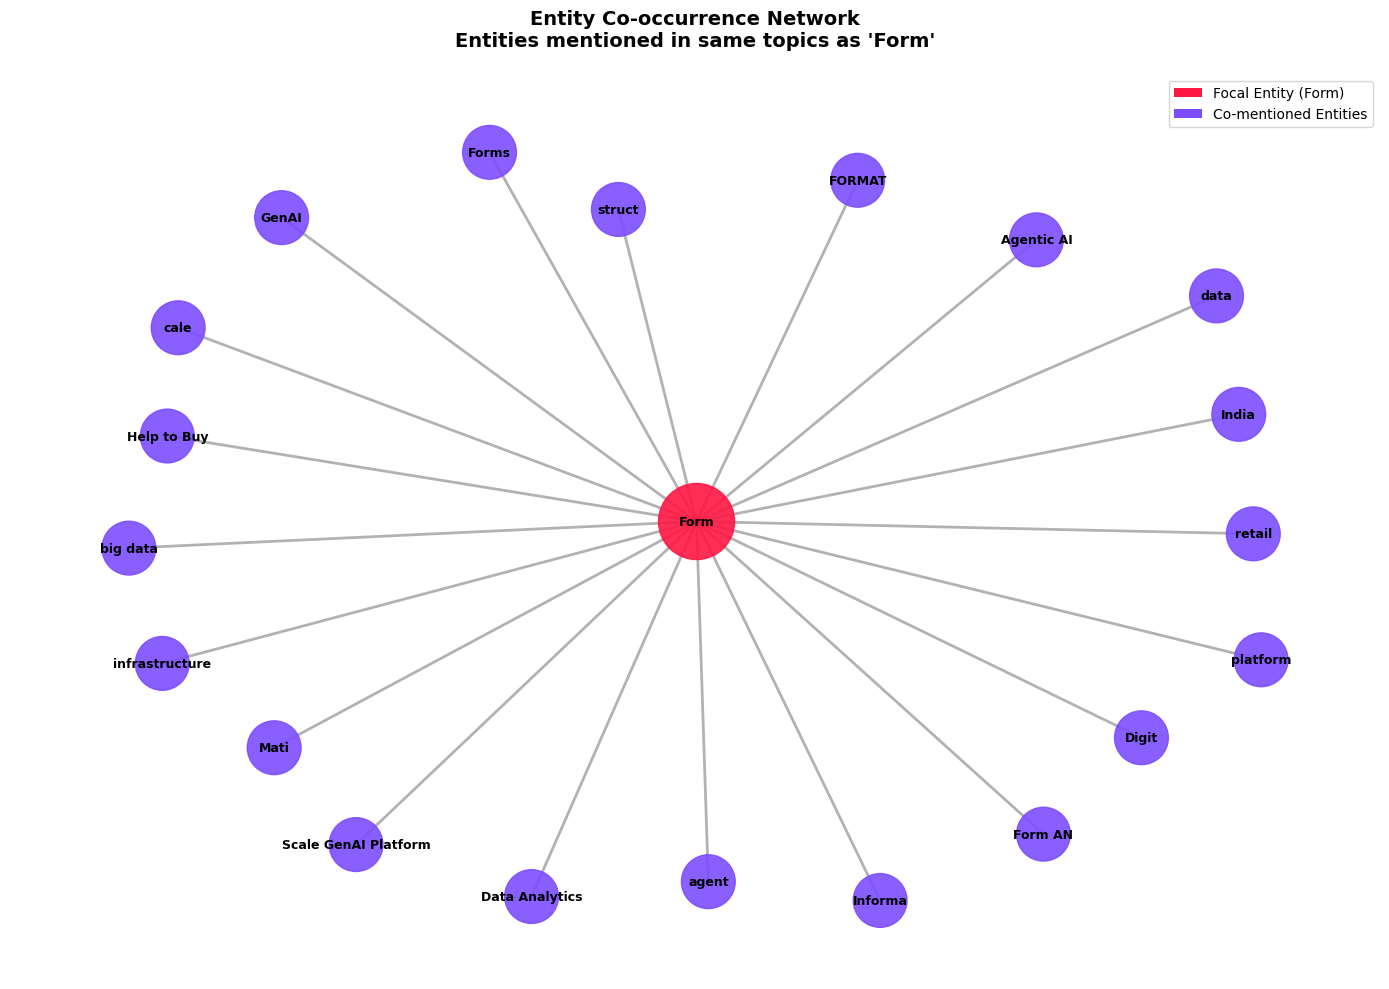


✓ Showing 20 entities co-mentioned with Form


In [45]:
# Example 4: Entity Relationship Visualization
print("🕸️  Entity Relationship Network")
print("="*60)

# Get a popular entity and its connections
popular_entities_query = """
MATCH (e:Entity)<-[:MENTIONS]-(t:Topic)
WITH e, count(t) as mention_count
WHERE mention_count > 3
RETURN e.name as entity, mention_count
ORDER BY mention_count DESC
LIMIT 5
"""

popular = neo4j_conn.query(popular_entities_query)
print("\nMost Mentioned Entities:")
for i, item in enumerate(popular, 1):
    print(f"  {i}. {item['entity']} ({item['mention_count']} mentions)")

# Build entity relationship network
if popular:
    focal_entity = popular[0]['entity']
    print(f"\n📍 Building network for: {focal_entity}")
    
    # Get entity connections
    entity_network_query = """
    MATCH (e1:Entity {name: $entity})<-[:MENTIONS]-(t:Topic)-[:MENTIONS]->(e2:Entity)
    WHERE e1 <> e2
    RETURN DISTINCT e1.name as entity1, e2.name as entity2, collect(DISTINCT t.topic_id)[0..2] as shared_topics
    LIMIT 20
    """
    
    connections = neo4j_conn.query(entity_network_query, entity=focal_entity)
    
    # Build NetworkX graph
    G_entity = nx.Graph()
    G_entity.add_node(focal_entity, node_type='focal')
    
    for conn in connections:
        G_entity.add_node(conn['entity2'], node_type='related')
        G_entity.add_edge(focal_entity, conn['entity2'])
    
    # Visualize
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G_entity, k=2, iterations=50, seed=42)
    
    # Color nodes
    node_colors = []
    for node in G_entity.nodes():
        if G_entity.nodes[node].get('node_type') == 'focal':
            node_colors.append('#FF1744')  # Red for focal
        else:
            node_colors.append('#7C4DFF')  # Purple for related
    
    # Draw
    nx.draw_networkx_nodes(G_entity, pos, node_color=node_colors, 
                          node_size=[3000 if G_entity.nodes[n].get('node_type') == 'focal' else 1500 
                                    for n in G_entity.nodes()],
                          alpha=0.9)
    nx.draw_networkx_edges(G_entity, pos, alpha=0.3, width=2)
    nx.draw_networkx_labels(G_entity, pos, font_size=9, font_weight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF1744', label=f'Focal Entity ({focal_entity})'),
        Patch(facecolor='#7C4DFF', label='Co-mentioned Entities')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.title(f"Entity Co-occurrence Network\nEntities mentioned in same topics as '{focal_entity}'", 
              fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Showing {len(G_entity.nodes())-1} entities co-mentioned with {focal_entity}")
else:
    print("No popular entities found")

🌳 Category-Topic Hierarchy

Top 5 Categories with Topics:

1. Technology & Innovation
   Activity: 5785, Topics: 5775
   Sample topics: 5 shown

2. Business & Finance
   Activity: 4062, Topics: 4061
   Sample topics: 5 shown

3. Wellness & Health
   Activity: 3442, Topics: 3442
   Sample topics: 5 shown

4. Travel & Transportation
   Activity: 2673, Topics: 2673
   Sample topics: 5 shown

5. Shopping & Retail
   Activity: 2558, Topics: 2558
   Sample topics: 5 shown


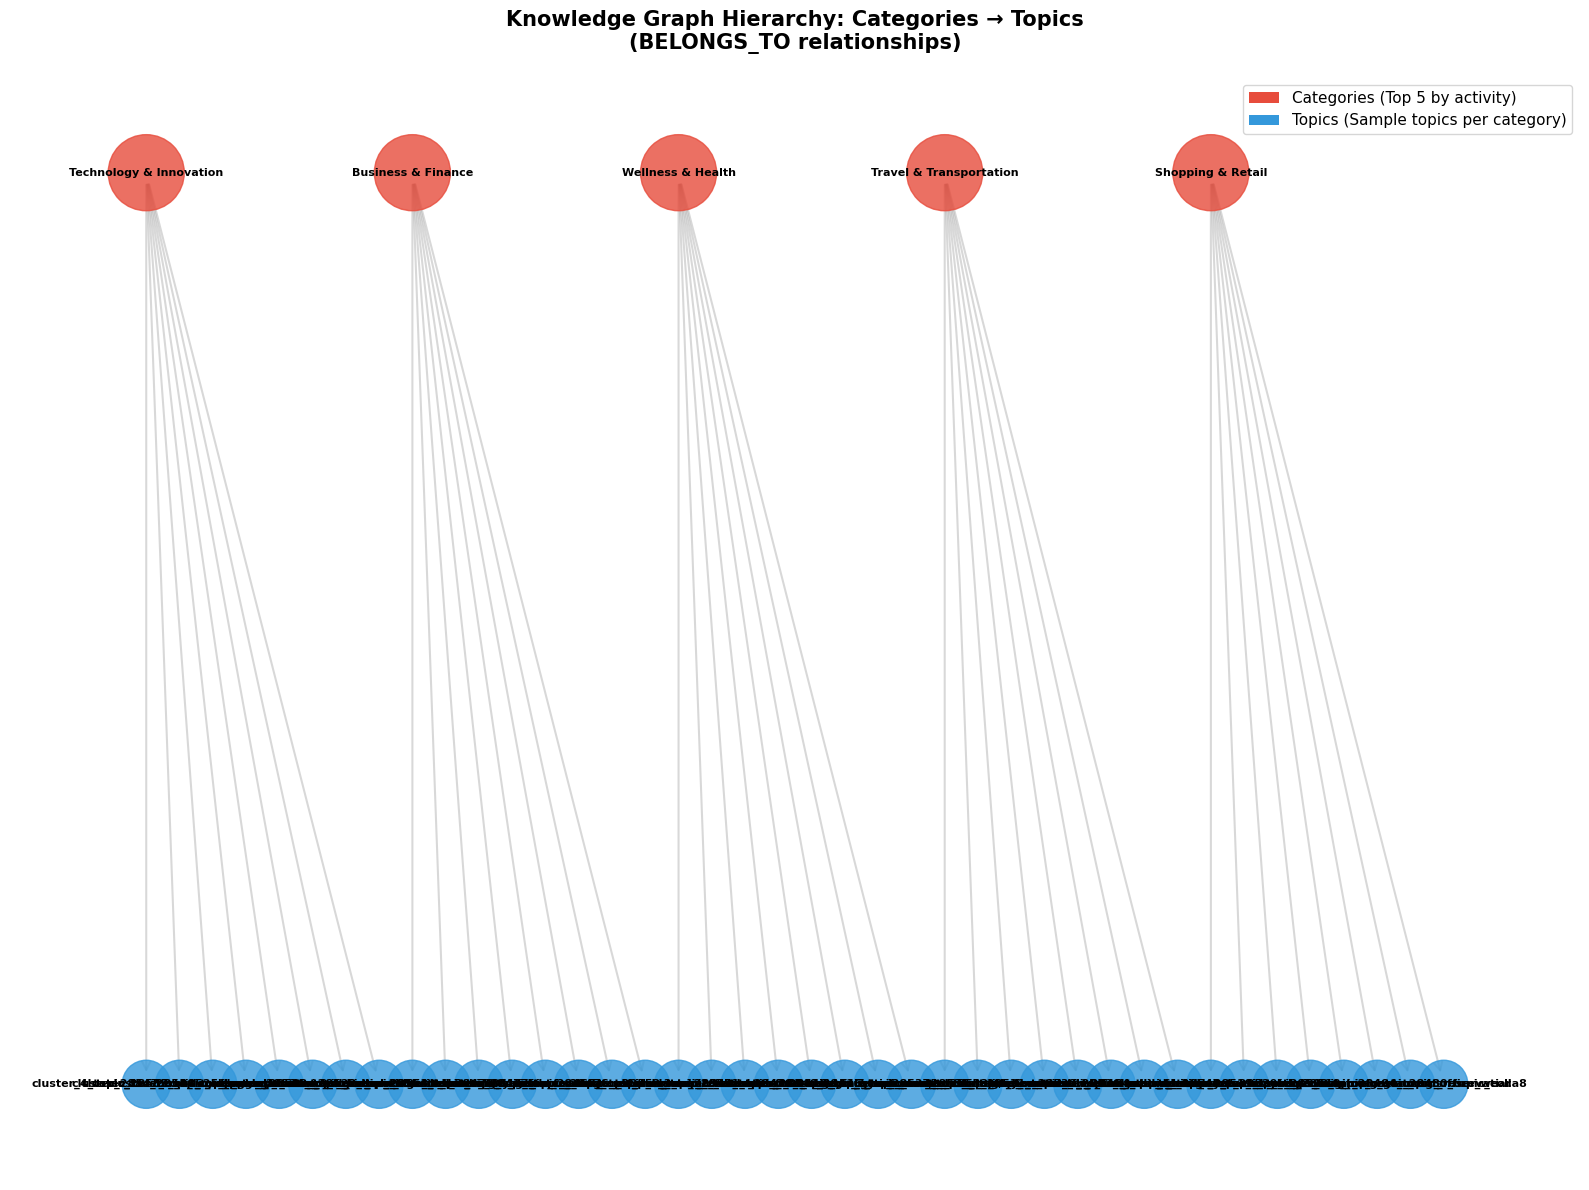


✓ Visualized 5 categories with 40 sample topics


In [46]:
# Example 6: Category-Topic Hierarchy Visualization
print("🌳 Category-Topic Hierarchy")
print("="*60)

# Get top categories with their topics
hierarchy_query = """
MATCH (c:Category)<-[:BELONGS_TO]-(t:Topic)
WITH c, c.activity_count AS activity,
     count(t) AS topic_count,
     collect(t.topic_id)[0..5] AS sample_topics
ORDER BY activity DESC
LIMIT 5
RETURN c.name AS category, activity, topic_count, sample_topics
"""

hierarchy = neo4j_conn.query(hierarchy_query)

print("\nTop 5 Categories with Topics:")
for i, cat in enumerate(hierarchy, 1):
    print(f"\n{i}. {cat['category']}")
    print(f"   Activity: {cat['activity']}, Topics: {cat['topic_count']}")
    print(f"   Sample topics: {len(cat['sample_topics'])} shown")

# Build hierarchical graph
G_hierarchy = nx.DiGraph()

for cat in hierarchy:
    cat_name = cat['category']
    G_hierarchy.add_node(cat_name, node_type='category', layer=0)
    
    # Get topics for this category
    topic_query = """
    MATCH (t:Topic)-[:BELONGS_TO]->(c:Category {name: $category})
    RETURN t.topic_id as topic
    LIMIT 8
    """
    topics = neo4j_conn.query(topic_query, category=cat_name)
    
    for topic in topics:
        topic_id = topic['topic'][:50]  # Truncate for display
        G_hierarchy.add_node(topic_id, node_type='topic', layer=1)
        G_hierarchy.add_edge(cat_name, topic_id)

# Create hierarchical layout
plt.figure(figsize=(16, 12))

# Use multipartite layout for hierarchy
layer_nodes = {
    0: [n for n, d in G_hierarchy.nodes(data=True) if d.get('layer') == 0],
    1: [n for n, d in G_hierarchy.nodes(data=True) if d.get('layer') == 1]
}

pos = {}
for layer, nodes in layer_nodes.items():
    y = 1 - layer * 0.5  # Top to bottom
    for i, node in enumerate(nodes):
        x = (i - len(nodes)/2) / max(len(nodes)/2, 1)
        pos[node] = (x, y)

# Color and size by node type
node_colors = []
node_sizes = []
for node in G_hierarchy.nodes():
    if G_hierarchy.nodes[node].get('node_type') == 'category':
        node_colors.append('#E74C3C')
        node_sizes.append(3000)
    else:
        node_colors.append('#3498DB')
        node_sizes.append(1200)

# Draw
nx.draw_networkx_nodes(G_hierarchy, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_hierarchy, pos, edge_color='gray', alpha=0.3, 
                      arrows=True, arrowsize=15, arrowstyle='->', width=1.5)

# Labels with better positioning
category_labels = {n: n for n in layer_nodes[0]}
topic_labels = {n: n[:40]+'...' if len(n) > 40 else n for n in layer_nodes[1]}
all_labels = {**category_labels, **topic_labels}

nx.draw_networkx_labels(G_hierarchy, pos, all_labels, font_size=8, font_weight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#E74C3C', label='Categories (Top 5 by activity)'),
    Patch(facecolor='#3498DB', label='Topics (Sample topics per category)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.title('Knowledge Graph Hierarchy: Categories → Topics\n(BELONGS_TO relationships)', 
         fontsize=15, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized {len(layer_nodes[0])} categories with {len(layer_nodes[1])} sample topics")


=== CREATING NETWORK VISUALIZATION ===

Graph created with 47 nodes and 53 edges
Visualizing: Technology & Innovation



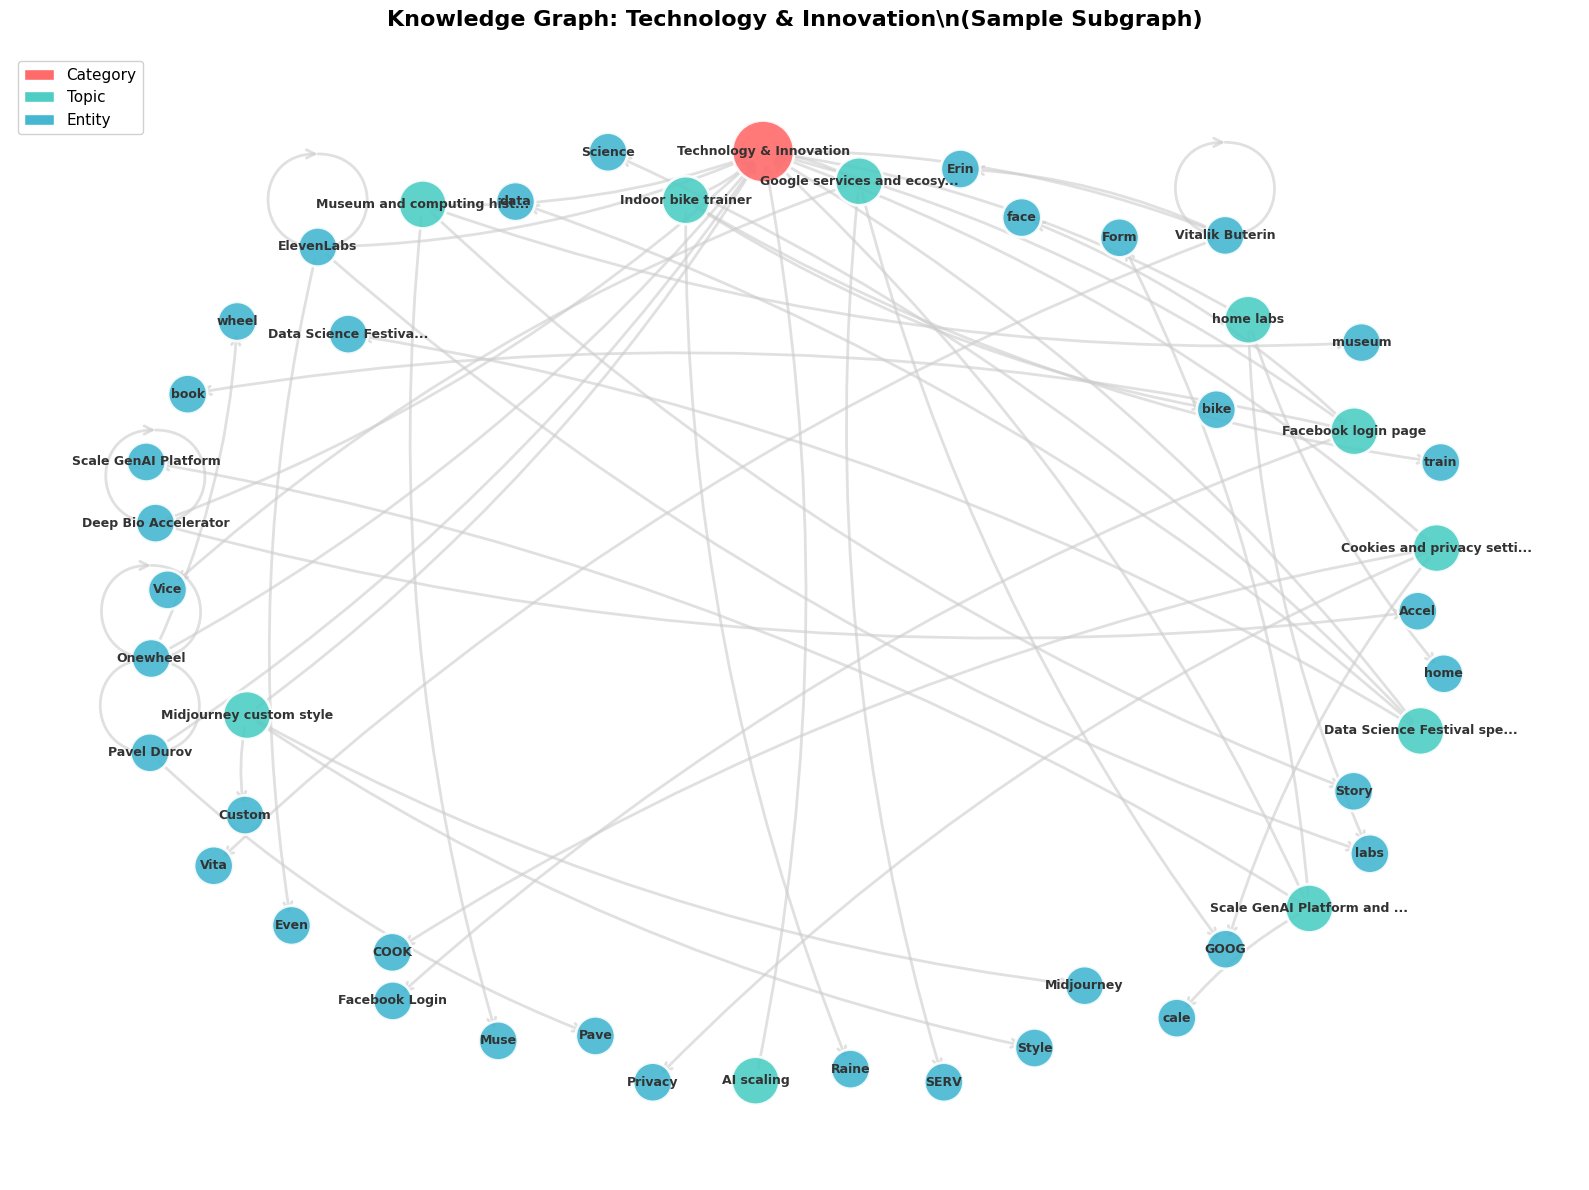

✓ Visualization complete


In [47]:
# Visualization: Create a sample network graph
if neo4j_conn:
    print("\n=== CREATING NETWORK VISUALIZATION ===\n")
    
    # Build a networkx graph from a sample category
    G = nx.DiGraph()
    
    # Get a focused subgraph for better visualization
    sample_query = """
    MATCH (c:Category)
    WITH c ORDER BY c.activity_count DESC LIMIT 1
    MATCH (t:Topic)-[:BELONGS_TO]->(c)
    OPTIONAL MATCH (t)-[:MENTIONS]->(e:Entity)
    RETURN 
        c.name as category,
        t.topic_id as topic,
        t.content as topic_content,
        collect(DISTINCT e.name) as entities
    LIMIT 15
    """
    
    results = neo4j_conn.query(sample_query)
    
    # Build graph
    category_name = None
    for result in results:
        if not category_name:
            category_name = result['category']
            G.add_node(category_name, node_type='Category')
        
        topic = result['topic_content'][:30] + "..." if len(result['topic_content']) > 30 else result['topic_content']
        G.add_node(topic, node_type='Topic')
        G.add_edge(topic, category_name, relationship='BELONGS_TO')
        
        # Add entities
        for entity in result['entities'][:3]:  # Limit entities per topic
            if entity:
                G.add_node(entity, node_type='Entity')
                G.add_edge(topic, entity, relationship='MENTIONS')
    
    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"Visualizing: {category_name}\n")
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Use hierarchical layout
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
    
    # Color nodes by type
    node_colors = []
    node_sizes = []
    color_map = {'Category': '#FF6B6B', 'Topic': '#4ECDC4', 'Entity': '#45B7D1'}
    size_map = {'Category': 2000, 'Topic': 1200, 'Entity': 800}
    
    for node in G.nodes():
        node_type = G.nodes[node].get('node_type', 'Unknown')
        node_colors.append(color_map.get(node_type, '#95E1D3'))
        node_sizes.append(size_map.get(node_type, 800))
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                          ax=ax, alpha=0.9, edgecolors='white', linewidths=2)
    nx.draw_networkx_edges(G, pos, edge_color='#CCCCCC', arrows=True, 
                          arrowsize=15, arrowstyle='->', ax=ax, 
                          connectionstyle='arc3,rad=0.1', alpha=0.6, width=2)
    
    # Draw labels
    labels = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('node_type')
        if node_type == 'Category':
            labels[node] = node
        elif node_type == 'Topic':
            labels[node] = node[:25] + '...' if len(node) > 25 else node
        else:
            labels[node] = node[:20] + '...' if len(node) > 20 else node
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, ax=ax, 
                           font_weight='bold', font_color='#333333')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', edgecolor='white', label='Category'),
        Patch(facecolor='#4ECDC4', edgecolor='white', label='Topic'),
        Patch(facecolor='#45B7D1', edgecolor='white', label='Entity')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.9)
    
    ax.set_title(f'Knowledge Graph: {category_name}\\n(Sample Subgraph)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete")

## 10 Summary

This notebook demonstrates:
1. **Vector Index Creation** - Neo4j native vector indexes for Categories, Topics, and Entities
2. **Semantic Search** - Query using natural language with `search_by_similarity()`
3. **Entity Networks** - Visualize co-occurrence patterns and relationships
4. **Graph Analytics** - Statistics, distributions, and hierarchical structures

The knowledge graph is now fully searchable with vector embeddings, enabling semantic queries without manual keyword matching.